In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 13.6 MB/s eta 0:00:00


In [ ]:
!pip install torchsummary

In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
#import pydicom
from skimage import transform
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk #for reading dicom img instead of pydicom
import numpy as np
from torchvision.transforms import transforms
import logging
from torchvision.utils import make_grid
from torch import nn
from torchsummary import summary
from tqdm import tqdm
from PIL import Image
import torch.optim as optim
import time



In [ ]:

from torch.nn import functional as F
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torch.utils.data import DataLoader
from torchvision.transforms import Resize

In [ ]:
import torch
print(torch.__version__)

2.5.0+cu121


In [ ]:
import torch
print(torch.__version__)

2.5.0+cu121


In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 21.0 MB/s eta 0:00:00


# Explore

In [ ]:
class CTScanDataset(Dataset):
    def __init__(self, file_paths, resize_size=(128,128)):
        self.file_paths = file_paths
        self.resize = transforms.Resize(resize_size)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        try:
            image = sitk.ReadImage(file_path)
            image_array = sitk.GetArrayFromImage(image)
            #logging.info(f"Successfully loaded image from {file_path}")

            # Convert to a tensor
            image_tensor = torch.tensor(image_array, dtype=torch.float32)

            # normalization
            min_val = torch.min(image_tensor)
            max_val = torch.max(image_tensor)
            normalized_image = (image_tensor - min_val) / (max_val - min_val) * 2 - 1
            #resize
            image_tensor = self.resize(normalized_image.unsqueeze(0)).squeeze(0)

            return image_tensor

        except Exception as e:
            #logging.error(f"Error reading {file_path}: {e}")
            new_idx = (idx + 1) % len(self.file_paths)
            return self.__getitem__(new_idx)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:23<00:00, 107MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
# Update file search pattern for JPEG files
file_paths = glob.glob(os.path.join(path, '**', '*.jpeg'), recursive=True)

if len(file_paths) == 0:
    print("No JPEG files found.")
else:
    print("Found", len(file_paths), "JPEG files")

    # Proceed with dataset creation and DataLoader setup
    dataset = CTScanDataset(file_paths, resize_size=(128,128))
    print("Length of dataset is:", len(dataset))

    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    print("Length of dataloader is (number of batches):", len(dataloader))

Found 11712 JPEG files
Length of dataset is: 11712
Length of dataloader is (number of batches): 92


In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):

    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()


Found 11712 JPEG files


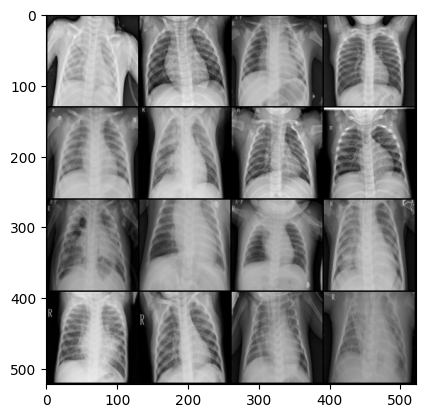

In [ ]:
import os
import glob
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Set up transformations to resize and convert images to tensor format
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensures 1 channel for grayscale
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Path to dataset
path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2"
file_paths = glob.glob(os.path.join(path, '**', '*.jpeg'), recursive=True)
print("Found", len(file_paths), "JPEG files")

# Load and transform images directly
def load_and_transform_images(file_paths):
    images = []
    for img_path in file_paths:
        image = Image.open(img_path)
        image = transform(image)  # Apply resizing and tensor conversion
        images.append(image)
    return images

# Load images and create DataLoader
images = load_and_transform_images(file_paths)
dataloader = DataLoader(images, batch_size=128, shuffle=True)

# Function to visualize a batch of images
def show_tensor_images(tensor_img, num_images=16, size=(1, 128, 128)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

# Display a batch
my_batch = next(iter(dataloader))
show_tensor_images(my_batch, num_images=16, size=(1, 128, 128))


# Models

In [ ]:
checkpoint_dir = './checkpoint_data2/'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
device = "cuda"

In [ ]:
D= Discriminator().to(device)
summary(D, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,024
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
        LeakyReLU-14           [-1, 102

In [ ]:
noise_dim = 100
# Create the generator model
G = Generator(noise_dim).to(device)
summary(G, (noise_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

# Checkpoints functions

In [ ]:
# Function to save checkpoints
def save_checkpoint(epoch, G, D, G_opt, D_opt, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'G_state_dict': G.state_dict(),
        'D_state_dict': D.state_dict(),
        'G_opt_state_dict': G_opt.state_dict(),
        'D_opt_state_dict': D_opt.state_dict(),
    }, checkpoint_path)

# Function to load checkpoints
def load_checkpoint(checkpoint_path, G, D, G_opt, D_opt):
    checkpoint = torch.load(checkpoint_path)
    G.load_state_dict(checkpoint['G_state_dict'])
    D.load_state_dict(checkpoint['D_state_dict'])
    G_opt.load_state_dict(checkpoint['G_opt_state_dict'])
    D_opt.load_state_dict(checkpoint['D_opt_state_dict'])
    return checkpoint['epoch']


# training  tests

In [ ]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):

    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()


In [ ]:
# Hyperparameters
batch_size = 128
epochs = 80
lr = 0.0002
beta1 = 0.5
noise_dim = 100  # Size of the latent vector (input noise)

# Initialize models
G = Generator(noise_dim).to(device)
D = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
G_opt = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
D_opt = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

g_losses = []
d_losses = []

In [ ]:
import os
import time
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Directory in Google Drive to save generated images
generated_images_dir = '/content/drive/MyDrive/generated_images'
os.makedirs(generated_images_dir, exist_ok=True)

# Initialize lists to store losses
g_losses = []
d_losses = []

print("Start training ....")
total_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print("Epoch:", epoch + 1)
    epoch_start_time = time.time()
    total_d_loss = 0.0
    total_g_loss = 0.0

    for batch_idx, real_img in enumerate(tqdm(dataloader)):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Update Discriminator
        D_opt.zero_grad()
        fake_img = G(noise)
        D_pred_fake = D(fake_img.detach())
        D_fake_loss = criterion(D_pred_fake, torch.zeros_like(D_pred_fake))
        D_pred_real = D(real_img)
        D_real_loss = criterion(D_pred_real, torch.ones_like(D_pred_real))
        disc_loss = (D_real_loss + D_fake_loss) / 2
        total_d_loss += disc_loss.item()
        disc_loss.backward()
        D_opt.step()

        # Update Generator
        G_opt.zero_grad()
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = criterion(D_pred, torch.ones_like(D_pred))
        total_g_loss += G_loss.item()
        G_loss.backward()
        G_opt.step()

        # Save each generated image in this epoch
        for i, image in enumerate(fake_img):
            img_path = os.path.join(generated_images_dir, f"epoch{epoch+1}_batch{batch_idx+1}_img{i+1}.png")
            image_cpu = image.detach().cpu().squeeze().numpy()
            plt.imsave(img_path, image_cpu, cmap='gray')

    # Calculate and store average losses
    avg_d_loss = total_d_loss / len(dataloader)
    avg_g_loss = total_g_loss / len(dataloader)
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    epoch_time = time.time() - epoch_start_time
    print(f"Discriminator loss = {avg_d_loss} | Generator loss = {avg_g_loss}")

    # Save model checkpoint
    save_checkpoint(epoch, G, D, G_opt, D_opt, checkpoint_dir)
    print(f"Time taken for epoch {epoch + 1}: {epoch_time:.2f} seconds")

# Save final checkpoint
save_checkpoint(epochs, G, D, G_opt, D_opt, checkpoint_dir)
print(f"Total training time: {total_time:.2f} seconds")


Mounted at /content/drive
Start training ....
Epoch: 1


100%|██████████| 92/92 [04:26<00:00,  2.90s/it]


Discriminator loss = 0.03563414430802526 | Generator loss = 8.84304990975753
Time taken for epoch 1: 267.00 seconds
Epoch: 2


100%|██████████| 92/92 [04:26<00:00,  2.89s/it]


Discriminator loss = 0.0007500189123042535 | Generator loss = 8.383131561071977
Time taken for epoch 2: 266.11 seconds
Epoch: 3


100%|██████████| 92/92 [04:19<00:00,  2.82s/it]


Discriminator loss = 0.4604238701170328 | Generator loss = 9.71070117732186
Time taken for epoch 3: 259.47 seconds
Epoch: 4


100%|██████████| 92/92 [04:18<00:00,  2.81s/it]


Discriminator loss = 0.6065855807746234 | Generator loss = 2.6571184195902036
Time taken for epoch 4: 258.80 seconds
Epoch: 5


100%|██████████| 92/92 [04:18<00:00,  2.81s/it]


Discriminator loss = 0.5477824478369692 | Generator loss = 2.578090838116148
Time taken for epoch 5: 258.32 seconds
Epoch: 6


100%|██████████| 92/92 [04:17<00:00,  2.80s/it]


Discriminator loss = 0.49278529798207077 | Generator loss = 2.810159637876179
Time taken for epoch 6: 257.93 seconds
Epoch: 7


100%|██████████| 92/92 [04:16<00:00,  2.79s/it]


Discriminator loss = 0.5542853775879611 | Generator loss = 2.585843225536139
Time taken for epoch 7: 256.38 seconds
Epoch: 8


100%|██████████| 92/92 [04:17<00:00,  2.80s/it]


Discriminator loss = 0.5137591397632724 | Generator loss = 2.665492350316566
Time taken for epoch 8: 257.22 seconds
Epoch: 9


100%|██████████| 92/92 [04:12<00:00,  2.75s/it]


Discriminator loss = 0.518556798281877 | Generator loss = 2.726899607673935
Time taken for epoch 9: 252.67 seconds
Epoch: 10


100%|██████████| 92/92 [04:08<00:00,  2.70s/it]


Discriminator loss = 0.5328113864297452 | Generator loss = 2.714975191037292
Time taken for epoch 10: 248.28 seconds
Epoch: 11


100%|██████████| 92/92 [04:02<00:00,  2.64s/it]


Discriminator loss = 0.49399306414567906 | Generator loss = 2.7491884723953577
Time taken for epoch 11: 242.74 seconds
Epoch: 12


100%|██████████| 92/92 [04:01<00:00,  2.63s/it]


Discriminator loss = 0.490366181925587 | Generator loss = 3.002191404933515
Time taken for epoch 12: 241.68 seconds
Epoch: 13


100%|██████████| 92/92 [04:06<00:00,  2.68s/it]


Discriminator loss = 0.47706931764664856 | Generator loss = 2.9908958517986797
Time taken for epoch 13: 246.52 seconds
Epoch: 14


100%|██████████| 92/92 [04:04<00:00,  2.65s/it]


Discriminator loss = 0.47611150242712186 | Generator loss = 3.0761923945468403
Time taken for epoch 14: 244.21 seconds
Epoch: 15


100%|██████████| 92/92 [04:09<00:00,  2.72s/it]


Discriminator loss = 0.45526604629729106 | Generator loss = 3.2690198058667392
Time taken for epoch 15: 249.92 seconds
Epoch: 16


100%|██████████| 92/92 [04:10<00:00,  2.72s/it]


Discriminator loss = 0.4010678280306899 | Generator loss = 3.5162643518136893
Time taken for epoch 16: 250.46 seconds
Epoch: 17


100%|██████████| 92/92 [04:07<00:00,  2.69s/it]


Discriminator loss = 0.3865521393068459 | Generator loss = 3.570594038652337
Time taken for epoch 17: 247.59 seconds
Epoch: 18


100%|██████████| 92/92 [04:11<00:00,  2.73s/it]


Discriminator loss = 0.3906002386432627 | Generator loss = 3.835373386092808
Time taken for epoch 18: 251.08 seconds
Epoch: 19


100%|██████████| 92/92 [04:03<00:00,  2.64s/it]


Discriminator loss = 0.3640801409340423 | Generator loss = 3.9084340152533157
Time taken for epoch 19: 243.10 seconds
Epoch: 20


100%|██████████| 92/92 [04:00<00:00,  2.61s/it]


Discriminator loss = 0.3571844373870155 | Generator loss = 4.013747272284134
Time taken for epoch 20: 240.38 seconds
Epoch: 21


100%|██████████| 92/92 [04:01<00:00,  2.63s/it]


Discriminator loss = 0.3703904257196447 | Generator loss = 4.136589418286863
Time taken for epoch 21: 241.98 seconds
Epoch: 22


100%|██████████| 92/92 [03:57<00:00,  2.59s/it]


Discriminator loss = 0.3359768935681685 | Generator loss = 4.123355836971946
Time taken for epoch 22: 237.92 seconds
Epoch: 23


100%|██████████| 92/92 [03:56<00:00,  2.57s/it]


Discriminator loss = 0.3446669690310955 | Generator loss = 4.141465056201686
Time taken for epoch 23: 236.38 seconds
Epoch: 24


100%|██████████| 92/92 [03:59<00:00,  2.60s/it]


Discriminator loss = 0.32328077227525087 | Generator loss = 4.448706670947697
Time taken for epoch 24: 239.59 seconds
Epoch: 25


100%|██████████| 92/92 [03:53<00:00,  2.54s/it]


Discriminator loss = 0.31270468558954156 | Generator loss = 4.344877526164055
Time taken for epoch 25: 233.71 seconds
Epoch: 26


100%|██████████| 92/92 [03:57<00:00,  2.58s/it]


Discriminator loss = 0.3148312371062196 | Generator loss = 4.445311655168948
Time taken for epoch 26: 237.13 seconds
Epoch: 27


100%|██████████| 92/92 [03:56<00:00,  2.57s/it]


Discriminator loss = 0.23964356878043516 | Generator loss = 4.6738869275735775
Time taken for epoch 27: 236.78 seconds
Epoch: 28


100%|██████████| 92/92 [03:56<00:00,  2.57s/it]


Discriminator loss = 0.28621002626807795 | Generator loss = 4.888755956421727
Time taken for epoch 28: 236.69 seconds
Epoch: 29


100%|██████████| 92/92 [04:07<00:00,  2.69s/it]


Discriminator loss = 0.3063199217228786 | Generator loss = 4.770325870617576
Time taken for epoch 29: 247.52 seconds
Epoch: 30


100%|██████████| 92/92 [04:00<00:00,  2.62s/it]


Discriminator loss = 0.2365147613150918 | Generator loss = 4.7903935883356175
Time taken for epoch 30: 240.80 seconds
Epoch: 31


100%|██████████| 92/92 [04:00<00:00,  2.61s/it]


Discriminator loss = 0.2107151100088073 | Generator loss = 4.880696504012398
Time taken for epoch 31: 240.19 seconds
Epoch: 32


100%|██████████| 92/92 [04:03<00:00,  2.65s/it]


Discriminator loss = 0.22812456613325555 | Generator loss = 4.955657825521801
Time taken for epoch 32: 243.69 seconds
Epoch: 33


100%|██████████| 92/92 [04:00<00:00,  2.61s/it]


Discriminator loss = 0.25933036594854103 | Generator loss = 5.163259412931359
Time taken for epoch 33: 240.56 seconds
Epoch: 34


100%|██████████| 92/92 [03:59<00:00,  2.60s/it]


Discriminator loss = 0.13446581525647122 | Generator loss = 5.047786634901295
Time taken for epoch 34: 239.61 seconds
Epoch: 35


100%|██████████| 92/92 [03:58<00:00,  2.59s/it]


Discriminator loss = 0.20719064270024715 | Generator loss = 5.885315358638763
Time taken for epoch 35: 238.44 seconds
Epoch: 36


100%|██████████| 92/92 [03:56<00:00,  2.58s/it]


Discriminator loss = 0.2342308694091828 | Generator loss = 5.491020653558814
Time taken for epoch 36: 236.99 seconds
Epoch: 37


100%|██████████| 92/92 [04:00<00:00,  2.61s/it]


Discriminator loss = 0.23376776269920493 | Generator loss = 5.690827315268309
Time taken for epoch 37: 240.32 seconds
Epoch: 38


 49%|████▉     | 45/92 [02:03<02:05,  2.68s/it]

In [ ]:
# Plot the generator and discriminator losses
plt.figure(figsize=(10,5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Generator and Discriminator Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Inception Score (IS) function
def calculate_inception_score(images, batch_size=32, splits=10):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()

    resize = Resize((299, 299))  # InceptionV3 expects 299x299 images
    preds = []
    with torch.no_grad():
        for batch in DataLoader(images, batch_size=batch_size):
            batch = batch.to(device)
            batch = resize(batch)  # Resize the images
            pred = model(batch)
            preds.append(F.softmax(pred, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Compute the inception score
    scores = []
    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits)]
        kl = part * (np.log(part) - np.log(np.mean(part, axis=0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))

    return np.mean(scores), np.std(scores)

In [ ]:
# Fréchet Inception Distance (FID) function
def calculate_fid(real_images, generated_images, batch_size=32):
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()

    resize = Resize((299, 299))  # InceptionV3 expects 299x299 images

    def get_activations(images):
        activations = []
        with torch.no_grad():
            for batch in DataLoader(images, batch_size=batch_size):
                batch = batch.to(device)
                batch = resize(batch)  # Resize the images
                pred = model(batch)
                activations.append(pred.cpu().numpy())
        return np.concatenate(activations, axis=0)

    real_activations = get_activations(real_images)
    fake_activations = get_activations(generated_images)

    # Calculate mean and covariance
    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake
    covmean, _ = sqrtm(sigma_real.dot(sigma_fake), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# evaluation test


In [ ]:
!pip install torch-fidelity

In [ ]:
checkpoint_dir = './check_data2eval/'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Hyperparameters
batch_size = 128
epochs = 80
lr = 0.0002
beta1 = 0.5
noise_dim = 100  # Size of the latent vector (input noise)

# Initialize models
G = Generator(noise_dim).to(device)
D = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
G_opt = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
D_opt = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

g_losses = []
d_losses = []

In [ ]:
import torch_fidelity
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np

# Initialize FID and Inception Score
fid = FrechetInceptionDistance().to(device)
inception = InceptionScore().to(device)

# Transform for resizing and normalizing images to Inception model's expected input
resize_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] which matches your normalized images
])

# Function to evaluate GAN using real and generated images
def evaluate_gan(real_images, generated_images):
    # Resize and normalize images for the Inception model
    real_images_resized = resize_transform(real_images)
    fake_images_resized = resize_transform(generated_images)

    # Update FID with real and fake images
    fid.update(real_images_resized, real=True)
    fid.update(fake_images_resized, real=False)

    # Update Inception Score with fake images
    inception.update(fake_images_resized)

    # Compute FID and Inception Score
    fid_score = fid.compute().item()
    inception_score = inception.compute()[0].item()

    print(f'FID Score: {fid_score}')
    print(f'Inception Score: {inception_score}')

    # Reset for the next epoch
    fid.reset()
    inception.reset()

# Your existing GAN training loop
for epoch in range(epochs):
    print("Epoch:", epoch + 1)

    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img in tqdm(dataloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Update Discriminator
        D_opt.zero_grad()

        # Fake loss
        fake_img = G(noise)
        D_pred_fake = D(fake_img.detach())
        D_fake_loss = criterion(D_pred_fake, torch.zeros_like(D_pred_fake))

        # Real loss
        D_pred_real = D(real_img)
        D_real_loss = criterion(D_pred_real, torch.ones_like(D_pred_real))

        # Total discriminator loss
        disc_loss = (D_real_loss + D_fake_loss) / 2
        total_d_loss += disc_loss.item()

        disc_loss.backward()
        D_opt.step()

        # Update Generator
        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = criterion(D_pred, torch.ones_like(D_pred))
        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

    # Calculate average losses for the epoch
    avg_d_loss = total_d_loss / len(dataloader)
    avg_g_loss = total_g_loss / len(dataloader)

    print(f"Discriminator loss = {avg_d_loss} | Generator loss = {avg_g_loss}")

    # Evaluate the GAN using real and generated images
    evaluate_gan(real_img, fake_img)

    # Save checkpoints, images, etc.
    save_checkpoint(epoch, G, D, G_opt, D_opt, checkpoint_dir)

# Save the final checkpoint after training
save_checkpoint(epochs, G, D, G_opt, D_opt, checkpoint_dir)


In [1]:
#Authored by Suhanee Hingorani and Krisha Aggarwal